In [1]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scvi
import torch
from scipy import stats
from adjustText import adjust_text
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [2]:
adata = sc.read('annotated.h5ad')
adata.obs

,samples,condition,location,n_genes,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,pct_counts_mt,pct_counts_ribo,pct_counts_hb,low_label,low_score,_scvi_batch,_scvi_labels,overcluster,low_major,Cell_Type
711_AAACCCAAGTCGGGAT-1,711,Tumor,Right,707,707,6.562444,1396.0,7.242083,26.862464,10.100286,25.716331,0.000000,T follicular helper cells,0.103311,0,0,14,CD4+ T cells,CD4+ T Cells
711_AAACCCACAGAGGAAA-1,711,Tumor,Right,838,838,6.732211,1504.0,7.316548,23.803191,9.441490,13.962767,0.000000,Unknown,0.236022,0,0,11,CD4+ T cells,CD4+ T Cells
711_AAACCCACATGATAGA-1,711,Tumor,Right,435,435,6.077642,613.0,6.419995,17.781403,0.815661,18.270800,0.000000,Unknown,0.400460,0,0,36,CMS3,CMS3
711_AAACCCAGTCTCGCGA-1,711,Tumor,Right,579,579,6.363028,860.0,6.758094,23.255814,15.465117,6.395349,0.000000,Tip-like ECs,0.966648,0,0,28,Tip-like ECs,Tip-like ECs
711_AAACGAAGTTATCTTC-1,711,Tumor,Right,1384,1384,7.233455,2629.0,7.874739,19.246862,8.178015,15.405098,0.000000,gamma delta T cells,0.993837,0,0,15,CD8+ T cells,CD8+ T cells
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706_TTTGGTTCAAACACCT-1,706,Tumor,Left,1815,1815,7.504392,4944.0,8.506132,21.318770,1.961974,21.318771,0.020227,CD8+ T cells,0.999997,0,0,1,CD8+ T cells,CD8+ T cells
706_TTTGGTTCAACGGGTA-1,706,Tumor,Left,909,909,6.813445,3528.0,8.168770,34.722222,0.368481,25.368483,0.000000,Pro-inflammatory,0.549964,0,0,12,SPP1+,Spp1+
706_TTTGGTTTCTATCGCC-1,706,Tumor,Left,4658,4658,8.446556,23600.0,10.069044,17.559322,3.237288,18.135593,0.004237,Stromal 2,0.961222,0,0,25,Stromal 2,Stromal 2
706_TTTGTTGCATCAGCGC-1,706,Tumor,Left,374,374,5.926926,686.0,6.532334,23.032070,10.932944,33.236153,0.000000,CMS2,0.978673,0,0,10,CMS2,CMS2


In [3]:
model = scvi.model.SCVI.load('the_model/', adata)
model

INFO     File the_model/model.pt already downloaded                                                                


SCVI model with the following parameters: 
n_hidden: 256, n_latent: 60, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: nb, 
latent_distribution: normal.
Training status: Trained
Model's adata is minified?: False

In [4]:
# Check sample sizes first
print("Sample sizes:")
print(adata[(adata.obs['condition'] == 'Tumor') & 
            (adata.obs['Cell_Type'] == 'CMS2')].shape[0], "CMS2 tumor cells")
print(adata[(adata.obs['condition'] == 'Tumor') & 
            (adata.obs['Cell_Type'] == 'CMS3')].shape[0], "CMS3 tumor cells")

# Main analysis: CMS2 vs CMS3 in tumor tissue
adata_tumor_cms = adata[(adata.obs['condition'] == 'Tumor') & 
                         (adata.obs['Cell_Type'].isin(['CMS2', 'CMS3']))].copy()

print(f"\nAnalyzing CMS2 vs CMS3 in tumor tissue...")
print(f"Total cells: {adata_tumor_cms.shape[0]}")

de_cms_tumor = model.differential_expression(
    adata_tumor_cms,
    groupby="Cell_Type",
    group1="CMS2",
    group2="CMS3",
    delta=0.5,
    fdr_target=0.05,
    mode='change',
    pseudocounts=1e-7,
    test_mode='two'
)
de_cms_tumor

Sample sizes:
1761 CMS2 tumor cells
2898 CMS3 tumor cells

Analyzing CMS2 vs CMS3 in tumor tissue...
Total cells: 4659
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
NPIPB4,0.9636,0.0364,3.276107,1.111247e-06,3.942705e-05,1.000000e-07,0.5,-4.878750,-4.949015,2.885451,...,0.002000,0.059959,0.010789,0.065562,0.015530,0.620076,True,CMS2 vs CMS3,CMS2,CMS3
TNFRSF10D,0.9584,0.0416,3.137165,4.643597e-06,1.176982e-04,1.000000e-07,0.5,-4.636146,-4.690820,2.897913,...,0.010268,0.209709,0.033504,0.196342,0.082087,2.289384,True,CMS2 vs CMS3,CMS2,CMS3
UVSSA,0.9568,0.0432,3.097754,3.301783e-06,5.544672e-05,1.000000e-07,0.5,-4.263220,-4.244465,2.708241,...,0.006774,0.093557,0.028961,0.105935,0.054355,0.978222,True,CMS2 vs CMS3,CMS2,CMS3
ANGPTL4,0.9566,0.0434,3.092926,9.223005e-06,1.620506e-04,1.000000e-07,0.5,-4.232399,-4.377873,2.933749,...,0.016354,0.266285,0.027825,0.234300,0.150584,2.870450,True,CMS2 vs CMS3,CMS2,CMS3
LINC01285,0.9560,0.0440,3.078568,1.595607e-06,5.842910e-05,1.000000e-07,0.5,-5.122988,-5.111756,4.239582,...,0.004082,0.091376,0.012493,0.075569,0.032602,0.992484,True,CMS2 vs CMS3,CMS2,CMS3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LINC00544,0.1986,0.8014,-1.395067,3.628325e-08,5.255620e-08,1.000000e-07,0.5,-0.324323,-0.350394,1.612153,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False,CMS2 vs CMS3,CMS2,CMS3
IL21-AS1,0.1900,0.8100,-1.450010,3.312774e-08,3.877053e-08,1.000000e-07,0.5,0.078482,0.083795,1.749551,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False,CMS2 vs CMS3,CMS2,CMS3
ITPKB-AS1,0.1876,0.8124,-1.465681,2.015915e-08,2.492195e-08,1.000000e-07,0.5,-0.642266,-0.627735,2.799715,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False,CMS2 vs CMS3,CMS2,CMS3
TRGV5P,0.1510,0.8490,-1.726779,1.312756e-08,3.171804e-08,1.000000e-07,0.5,-1.131962,-1.122780,2.362002,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False,CMS2 vs CMS3,CMS2,CMS3


In [ ]:
scvi_de = scvi_de[(scvi_de['is_de_fdr_0.05']) & (abs(scvi_de.lfc_mean) > .5)]
scvi_de = scvi_de.sort_values('lfc_mean')
scvi_de

In [5]:
# Filter significant genes
de_cms_filtered = de_cms_tumor[(de_cms_tumor['is_de_fdr_0.05']) & (abs(de_cms_tumor.lfc_mean) > 0.5)
].sort_values('lfc_mean', key=abs, ascending=False)

print(f"\nSignificant DEGs: {len(de_cms_filtered)}")
print(f"UP in CMS2 (vs CMS3): {(de_cms_filtered['lfc_mean'] > 0).sum()}")
print(f"UP in CMS3 (vs CMS2): {(de_cms_filtered['lfc_mean'] < 0).sum()}")


Significant DEGs: 30
UP in CMS2 (vs CMS3): 0
UP in CMS3 (vs CMS2): 30


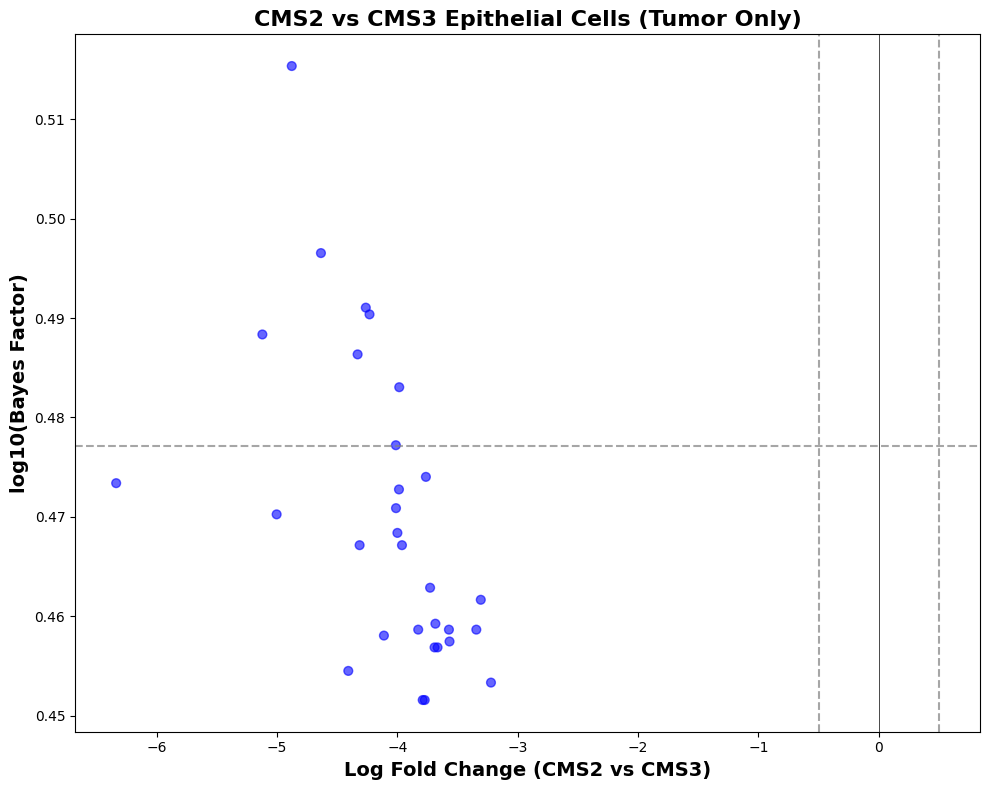

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))
de_cms_filtered['log10_bf'] = np.log10(de_cms_filtered['bayes_factor'] + 1e-10)

colors = ['red' if x > 0 else 'blue' for x in de_cms_filtered['lfc_mean']]

ax.scatter(de_cms_filtered['lfc_mean'], de_cms_filtered['log10_bf'],
           c=colors, alpha=0.6, s=40)

ax.axhline(y=np.log10(3), color='gray', linestyle='--', alpha=0.7)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7)
ax.axvline(x=-0.5, color='gray', linestyle='--', alpha=0.7)

ax.set_xlabel('Log Fold Change (CMS2 vs CMS3)', fontsize=14, fontweight='bold')
ax.set_ylabel('log10(Bayes Factor)', fontsize=14, fontweight='bold')
ax.set_title('CMS2 vs CMS3 Epithelial Cells (Tumor Only)', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.savefig('volcano_CMS2_vs_CMS3_tumor.pdf', dpi=300, bbox_inches='tight')
plt.show()